In [44]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [45]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [46]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [47]:
def factor(df, window=20):
    """
    改进：引入分形市场理论，识别不同波动周期中的重心变化
    金融意义：捕捉市场结构变化，识别趋势转折点
    """
    df = df.copy()
    # 计算波动率分形维度
    df['range'] = (df['high'] - df['low']) / df['open']
    df['fractal'] = df['range'].rolling(5).std() / df['range'].rolling(20).std()
    
    daily_results = []
    for date, group in df.groupby(pd.Grouper(freq='D')):
        if len(group) < 4:
            continue
            
        time_idx = np.arange(len(group))
        # 分形维度加权
        fractal_weights = group['fractal'].values
        
        # 上涨K线分形加权重心
        up_mask = group['close'] > group['open']
        if up_mask.any():
            up_weights = fractal_weights[up_mask] * group.loc[up_mask, 'volume']
            G_u = np.sum(time_idx[up_mask] * up_weights) / up_weights.sum()
        else:
            G_u = np.nan
            
        # 下跌K线分形加权重心
        down_mask = group['close'] < group['open']
        if down_mask.any():
            down_weights = fractal_weights[down_mask] * group.loc[down_mask, 'volume']
            G_d = np.sum(time_idx[down_mask] * down_weights) / down_weights.sum()
        else:
            G_d = np.nan
            
        daily_results.append({
            'date': date,
            'G_u': G_u,
            'G_d': G_d,
            'avg_fractal': fractal_weights.mean()
        })
    
    daily_df = pd.DataFrame(daily_results).set_index('date')
    
    # 分形状态感知回归
    residuals = []
    for i in range(window, len(daily_df)):
        train_data = daily_df.iloc[i-window:i].dropna()
        if len(train_data) < 10:
            residuals.append(np.nan)
            continue
            
        # 分形状态作为交互项
        X = train_data[['G_u', 'avg_fractal']].values
        y = train_data['G_d'].values
        model = LinearRegression().fit(X, y)
        
        current = daily_df.iloc[i]
        if pd.isna(current['G_u']) or pd.isna(current['G_d']):
            residuals.append(np.nan)
        else:
            pred_G_d = model.predict([[current['G_u'], current['avg_fractal']]])[0]
            residuals.append(current['G_d'] - pred_G_d)
    
    daily_df = daily_df.iloc[window:]
    daily_df['residual'] = residuals
    
    # 分形波动调整
    fractal_level = daily_df['avg_fractal'].rolling(5).mean()
    daily_df['factor'] = daily_df['residual'] * fractal_level
    
    df['factor_value'] = np.nan
    for date, row in daily_df.iterrows():
        mask = (df.index.date == date.date())
        df.loc[mask, 'factor_value'] = row['factor']
    
    return (-df['factor_value']).clip(upper=12)

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.045254
   Rank_IC (Spearman): 0.033699
📊 信息比率:
   IR: -0.229404
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 128731
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


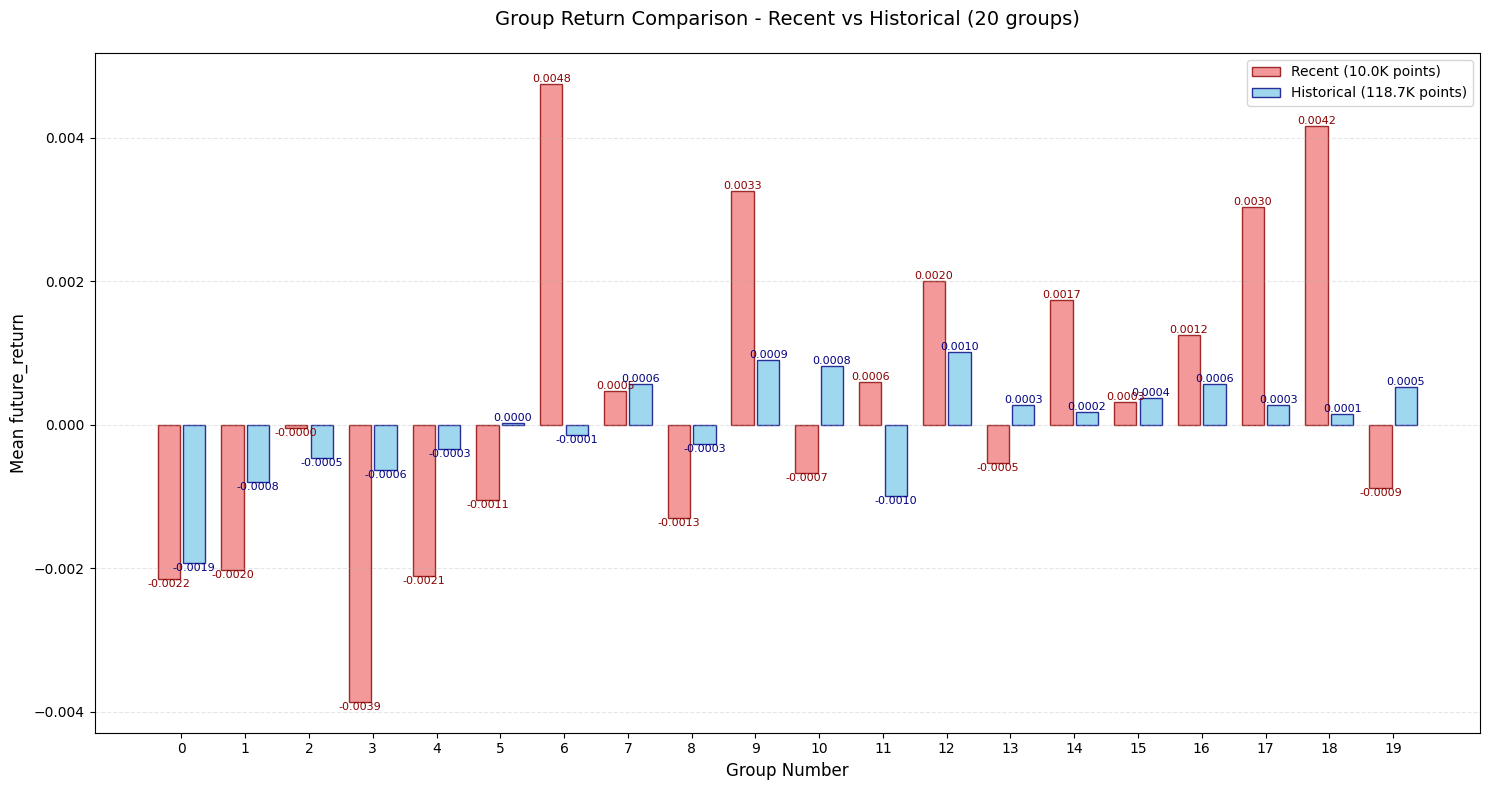

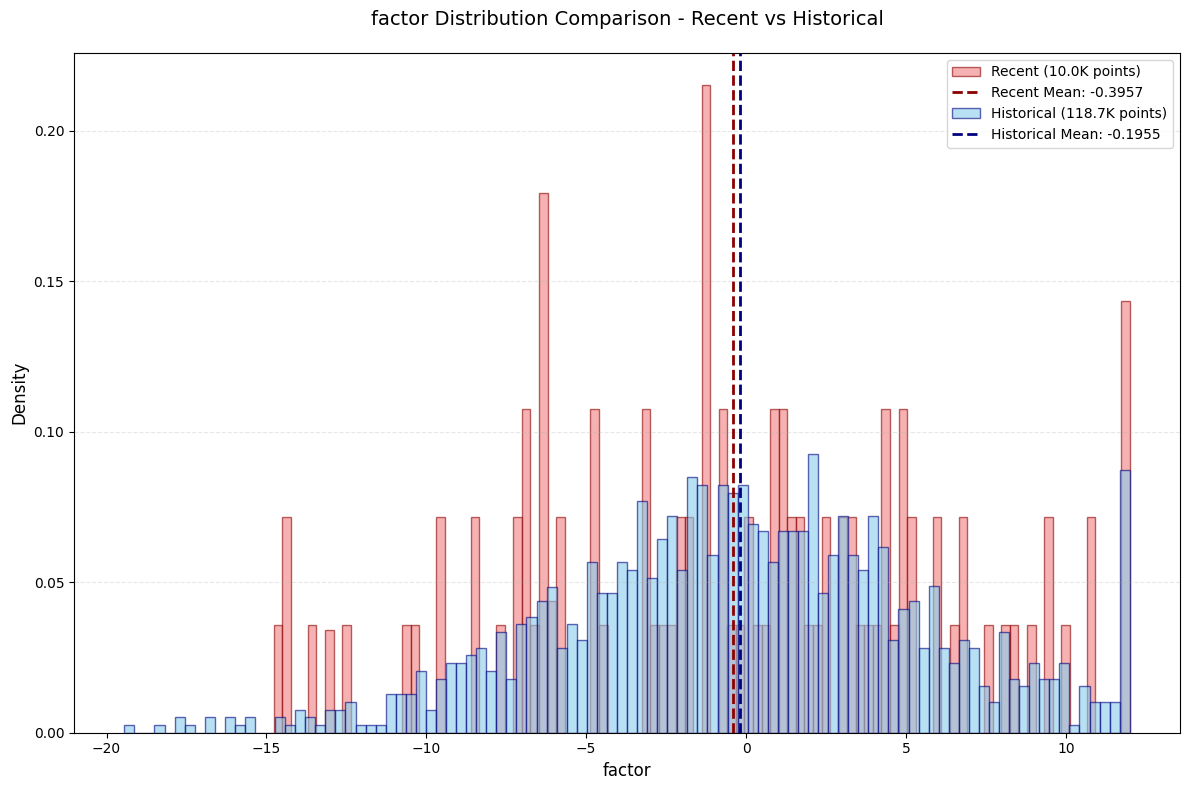

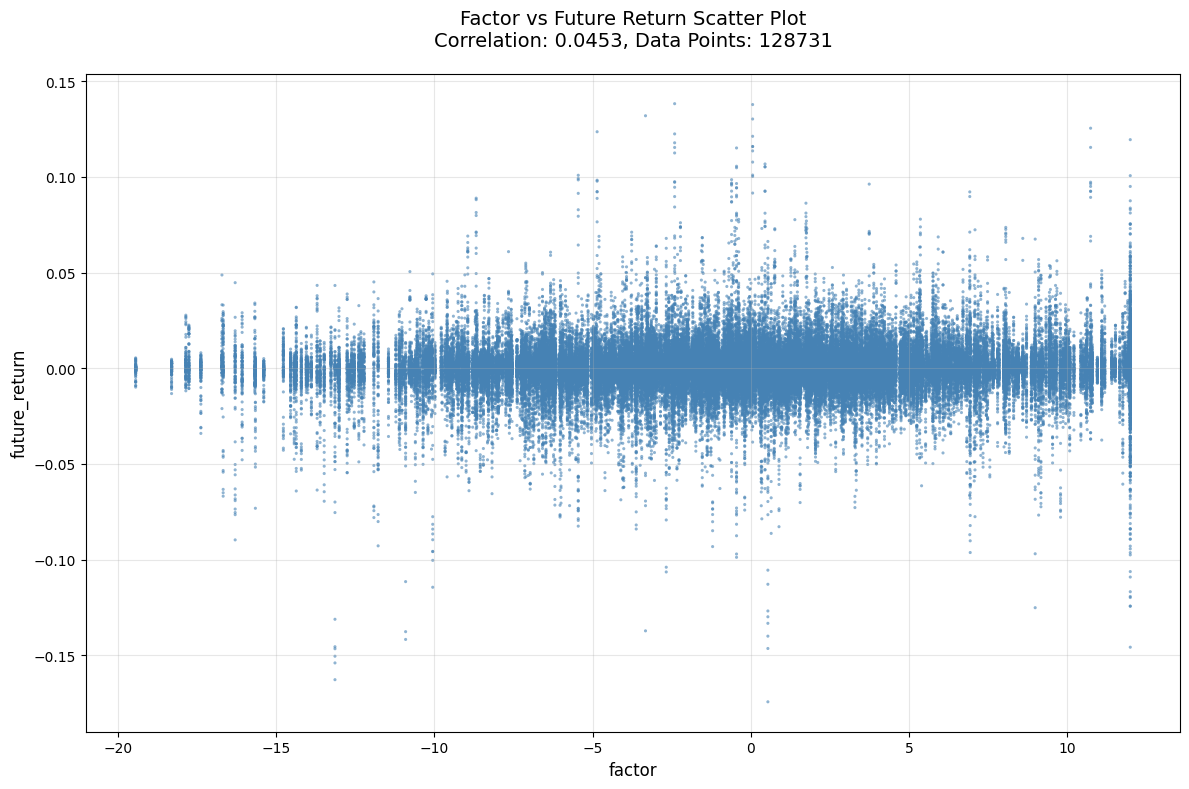

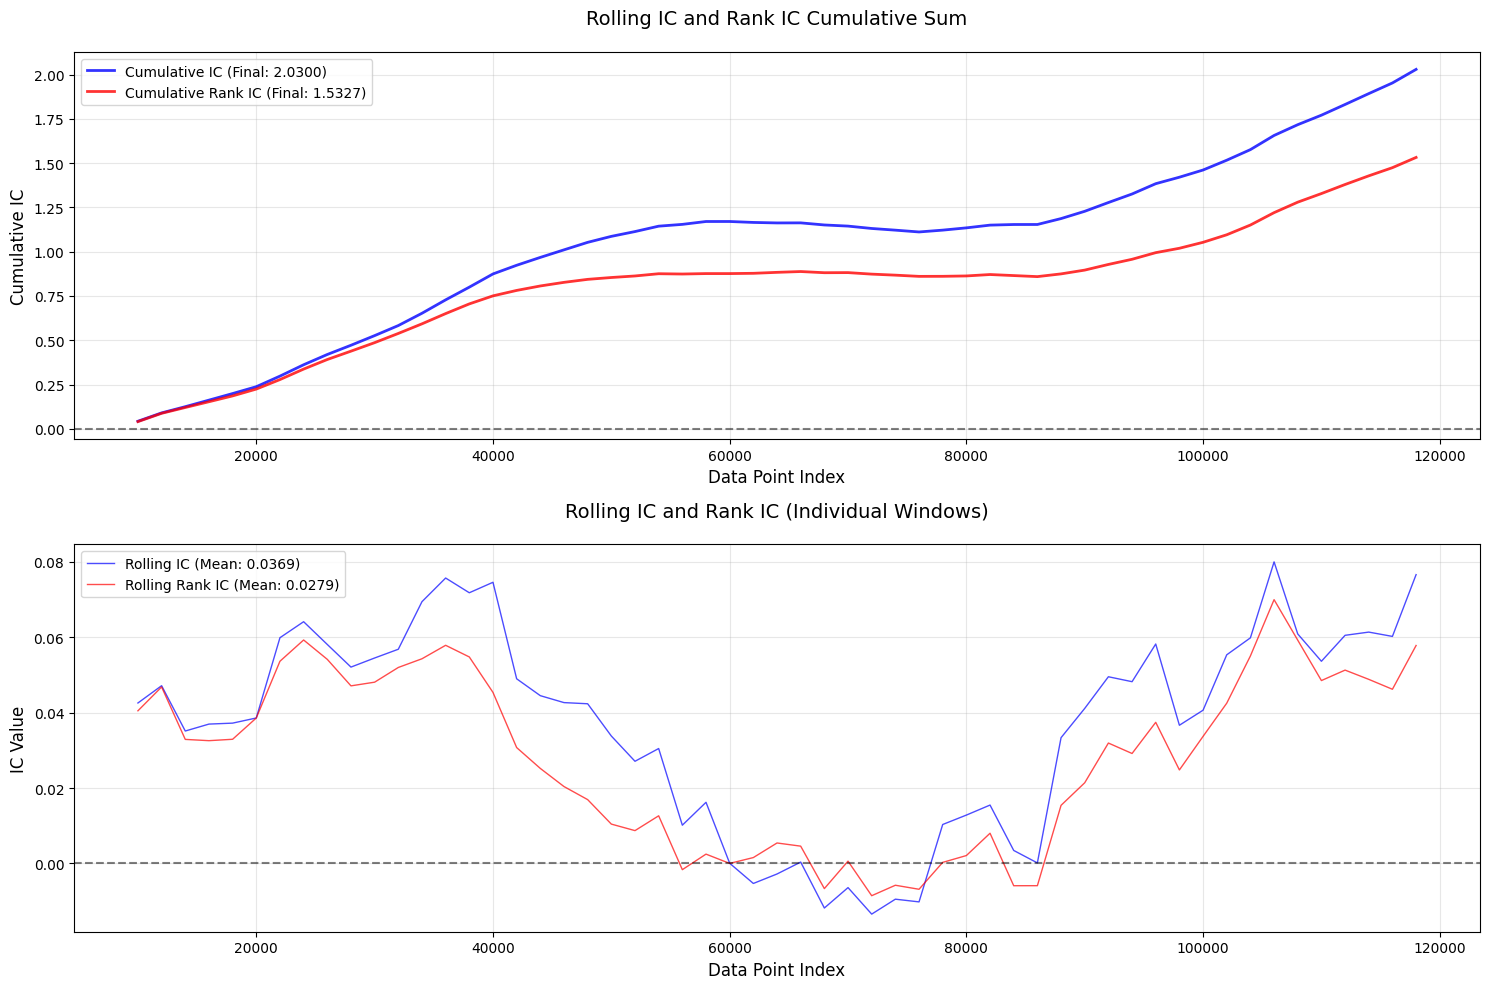

✅ 已显示 4 个图片
----------------------------------------


In [48]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [49]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[0.028596878554364453,
 -0.0059734265489050095,
 -0.007201828602226062,
 -0.00420796110399755,
 0.03306485157386855,
 -0.05614932122415626,
 -0.0280769844982311,
 -0.00584865907246881,
 -0.023491661734871605,
 0.011515315382877322]

In [50]:
print(result)

{'correlation_analysis': {'IC': 0.0452541355416024, 'Rank_IC': 0.033699142506178684}, 'information_ratio': {'IR': -0.22940380453776674, 'group_correlations': [0.028596878554364453, -0.0059734265489050095, -0.007201828602226062, -0.00420796110399755, 0.03306485157386855, -0.05614932122415626, -0.0280769844982311, -0.00584865907246881, -0.023491661734871605, 0.011515315382877322], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0     -19.4450  -9.7580  -12.7462      -0.0021      0.0142   6523
1      -9.6614  -7.5818   -8.5927      -0.0009      0.0121   6432
2      -7.5789  -6.2488   -6.8273      -0.0004      0.0115   6432
3      -6.2385  -4.9149   -5.6206      -0.0009      0.0118   6432
4      -4.9123  -3.9213   -4.4102      -0.0003      0.0110   6432
5      -3.9016  -3.0855   -3.4307      -0.0001      0.0118   6432
6      -3.0789  -2.2726   -2.6324      